# Import Library

In [230]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely import wkt

# Read Data

In [231]:
# Charger le DataFrame à partir du fichier pickle créé dans le premier notebook
with open('Data/data_concatenated.pkl', 'rb') as f:
    dataframe = pickle.load(f)
display(dataframe)

,Identifiant de document,Reference document,1 Articles CGI,2 Articles CGI,3 Articles CGI,4 Articles CGI,5 Articles CGI,No disposition,Date mutation,Nature mutation,...,Surface Carrez du 5eme lot,Nombre de lots,Code type local,Type local,Identifiant local,Surface reelle bati,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain
1430589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,04/01/2022,Vente,...,NaN,0,1.0,Maison,NaN,71.0,4.0,S,NaN,70.0
1430593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,05/01/2022,Vente,...,NaN,1,2.0,Appartement,NaN,40.0,1.0,NaN,NaN,NaN
1430601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,07/01/2022,Vente,...,NaN,1,2.0,Appartement,NaN,35.0,1.0,NaN,NaN,NaN
1430609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,03/01/2022,Vente,...,NaN,0,1.0,Maison,NaN,65.0,3.0,S,NaN,45.0
1430614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,05/01/2022,Vente,...,NaN,1,2.0,Appartement,NaN,20.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10428037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,29/12/2020,Vente,...,NaN,1,2.0,Appartement,NaN,83.0,4.0,NaN,NaN,NaN
10428064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,29/12/2020,Vente,...,NaN,0,1.0,Maison,NaN,119.0,6.0,S,NaN,545.0
10428093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,30/12/2020,Vente,...,NaN,0,1.0,Maison,NaN,76.0,4.0,S,NaN,251.0
10428225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,23/12/2020,Vente,...,NaN,0,1.0,Maison,NaN,41.0,2.0,S,NaN,110.0


# Data Preprocessing

In [232]:
# Calcul du pourcentage de valeurs non nulles par colonne
pourcentage_non_null = (dataframe.count() / len(dataframe)) * 100

# Création d'un DataFrame avec le pourcentage de non-null par colonne
resultat = pd.DataFrame({'Pourcentage Non-Null': pourcentage_non_null})

# Tri par pourcentage de non-null de manière décroissante
resultat = resultat.sort_values(by='Pourcentage Non-Null', ascending=False)

# Affichage du résultat trié
print("Pourcentage de non-null par colonne (trié) :")
print(resultat)

Pourcentage de non-null par colonne (trié) :
                            Pourcentage Non-Null
Nature mutation                       100.000000
Date mutation                         100.000000
Code postal                           100.000000
Voie                                  100.000000
Code voie                             100.000000
Nombre de lots                        100.000000
No plan                               100.000000
Code departement                      100.000000
Commune                               100.000000
No disposition                        100.000000
Code type local                       100.000000
Type local                            100.000000
Surface reelle bati                   100.000000
Nombre pieces principales             100.000000
Code commune                          100.000000
Type de voie                           99.980179
No voie                                99.876121
Valeur fonciere                        99.871166
Section                 

## Data Cleaning

In [233]:
#colonne rempli que de na
colonnes_to_drop = ['Identifiant de document', 'Reference document', '1 Articles CGI', "Identifiant local",
       '2 Articles CGI', '3 Articles CGI', '4 Articles CGI', '5 Articles CGI',"Commune", "Prefixe de section", "No Volume", "Nombre de lots"]
dataframe = dataframe.drop(columns = colonnes_to_drop)

In [234]:
#Supprimer les lignes ou valeur foncière = 0 et ou il n'y a pas de section
dataframe = dataframe.dropna(subset = ["Valeur fonciere"])
dataframe = dataframe.dropna(subset = ["Section"])

In [235]:
#Supprimer la colonne Code commune car il y a qu'une seul valeur 63
dataframe = dataframe.drop(columns = ["Code commune"])

In [236]:
#Le Code Voie nous pose problème car si lors de la prédiction nous n'avons le code voie la prédictions risque d'être mauvaise

In [237]:
#Tous les colonnes de lots ne servent à rien
dataframe = dataframe.drop(columns = ['1er lot', 
                        'Surface Carrez du 1er lot', 
                        '2eme lot', 
                        'Surface Carrez du 2eme lot',
                        '3eme lot', 'Surface Carrez du 3eme lot', 
                        '4eme lot',       
                        'Surface Carrez du 4eme lot', 
                        '5eme lot', 
                        'Surface Carrez du 5eme lot',
                        'No disposition'] )

In [238]:
dataframe["Valeur fonciere"] = dataframe["Valeur fonciere"].apply(lambda x: int(float(str(x).replace(',', '.'))) if pd.notna(x) else x)

In [239]:
dataframe["Date mutation"] = pd.to_datetime(dataframe["Date mutation"], dayfirst=True)

In [240]:
dataframe["Month"] = dataframe["Date mutation"].dt.month

In [241]:
dataframe["Year"] = dataframe["Date mutation"].dt.year

In [242]:
#On drop les individus avec une Nature Echange
dataframe = dataframe[dataframe["Nature mutation"] != "Echange"]
dataframe = dataframe[dataframe["Nombre pieces principales"] != 0.]

In [243]:
dataframe["Prix m2"] = dataframe["Valeur fonciere"]/ dataframe["Surface reelle bati"]

In [244]:
dataframe = dataframe[dataframe["Prix m2"]>2000]

## Data Grouping

In [245]:
def adresse(row):
    if pd.isna(row["B/T/Q"]):
        return str(row["No voie"]) + " " + str(row["Type de voie"]) + " " + str(row["Voie"]) + " " + str(row["Code postal"]) + str(row["Date mutation"]) + str(row["Valeur fonciere"])
    else:
        return str(row["No voie"]) + str(row["B/T/Q"]) + " " +str(row["Type de voie"]) + " " + str(row["Voie"]) + " " + str(row["Code postal"]) + str(row["Date mutation"]) + str(row["Valeur fonciere"])

dataframe["adresse"] = dataframe.apply(adresse, axis = 1)
def unique_list(serie):
    cleaned_list = [x for x in serie if x is not None and x == x]
    cleaned_list = list(set(cleaned_list))
    if len(cleaned_list) == 1:
        return cleaned_list[0]
    if len(cleaned_list) == 0:
        return np.nan
    else:
        return sum(cleaned_list)
    

dataframe_grouped = dataframe.groupby("adresse")[["Valeur fonciere", "Section", "Code type local", "Surface reelle bati", "Nombre pieces principales", "Surface terrain", "Month", "Year", "Prix m2"]].agg([unique_list])
dataframe_grouped["Prix m2"] = dataframe_grouped["Valeur fonciere"] / dataframe_grouped["Surface reelle bati"]
dataframe_grouped.columns = [x[0] for x in dataframe_grouped.columns]
dataframe_grouped = dataframe_grouped[(dataframe_grouped["Prix m2"]>2000) & (dataframe_grouped["Prix m2"]<10000)]
dataframe_grouped = dataframe_grouped.drop(columns = ["Prix m2"])
dataframe_grouped= dataframe_grouped.drop_duplicates()

In [246]:
conditions = pd.isna(dataframe_grouped["Surface terrain"])
dataframe_grouped.loc[conditions, ["Surface terrain"]] = dataframe_grouped.loc[conditions, "Surface reelle bati"] + 1

## Traitement Geospatial

### Import library

In [ ]:
import geopandas as gpd
from shapely import wkt
import pyproj
from shapely.ops import transform
from shapely.geometry import Point, Polygon, MultiPolygon
proj_lambert93 = pyproj.CRS('EPSG:2154')
proj_wgs84 = pyproj.CRS('EPSG:4326')

### Read Data

In [ ]:
# Supposons que gdf1 est votre DataFrame pandas et que la colonne 'geometry' contient des chaînes WKT
gdf1 = pd.read_csv("Data/gdf1.csv")

# Convertir les chaînes WKT en objets géométriques
gdf1['geometry'] = gdf1['geometry'].apply(wkt.loads)

# Créer un GeoDataFrame
gdf1 = gpd.GeoDataFrame(gdf1, geometry='geometry')
gdf1.set_crs("EPSG:2154", inplace=True)
gdf1.loc[pd.isna(gdf1["Section"]), "Section"] = "NA"

### Function

In [247]:
def distance_centre(row):
    return row['centroid'].distance(row['centroid_grouped'])

def test_union_polygon(poly1, poly2):
    union_result = poly1.union(poly2)
    return isinstance(union_result, Polygon)


def convert_point(point):
        return transform(pyproj.Transformer.from_crs(proj_lambert93, proj_wgs84, always_xy=True).transform, point)


def df_section_grouped(df_nb_section, df_section_geometry, n_min):

    #merge nb_section with geometry 
    df_nb_section_geometry = df_nb_section.merge(
        df_section_geometry, 
        on = "Section",
        how = "right",
        validate = "one_to_one",
        ).sort_values(by = "Code type local").reset_index(drop = True).rename(columns = {"geometry" : "geometry_grouped"})
        
    #all section not in nb_section have 0 record
    df_nb_section_geometry["Code type local"] = df_nb_section_geometry["Code type local"].fillna(0)


    # Convertir le DataFrame en GeoDataFrame
    gdf_nb_section_geometry = gpd.GeoDataFrame(df_nb_section_geometry, geometry='geometry_grouped')

    # Calculer le centroïde pour chaque section
    gdf_nb_section_geometry['centroid_grouped'] = gdf_nb_section_geometry['geometry_grouped'].centroid
        
    # Extraire les codes des sections faible
    section_faible_codes = gdf_nb_section_geometry[gdf_nb_section_geometry['Code type local']<=n_min]


    while not(section_faible_codes.empty) :

        print("section_faible", len(section_faible_codes["Code type local"]))
        print("gdf",len(gdf_nb_section_geometry["Code type local"]))
    
        for index, section_faible in section_faible_codes.iterrows():
            if section_faible["Section"] in gdf_nb_section_geometry["Section"].unique():
                #clear Data
                gdf_nb_section_geometry = gdf_nb_section_geometry.reset_index(drop = True)
                gdf_nb_section_geometry['touches_polygon1'] = False
                gdf_nb_section_geometry['distance'] = np.nan


                #filter on near section
                gdf_nb_section_geometry['touches_polygon'] = gdf_nb_section_geometry['geometry_grouped'].apply(lambda x: test_union_polygon(x, section_faible["geometry_grouped"]))
                conditions = (gdf_nb_section_geometry["Section"] != str(section_faible["Section"])) & (gdf_nb_section_geometry['touches_polygon'] == True)
            

                #compute distance
                gdf_nb_section_geometry.loc[conditions, 'distance'] = gdf_nb_section_geometry.loc[conditions, 'centroid_grouped'].apply(lambda x: section_faible['centroid_grouped'].distance(x))

                #recovery near section index
                min_section = gdf_nb_section_geometry.iloc[gdf_nb_section_geometry["distance"].idxmin()]

                #set new name groupe
                try:
                    groupe_set = set([section_faible["Section"], min_section["Section"]])   
                    groupe_name = " ".join(groupe_set)
                except:
                     raise ValueError('min_section["Section"]', min_section["Section"],  'section_faible["Section"]', section_faible["Section"])

                #create new group
                nouveau_groupe = {
                    "Section" : groupe_name, 
                    "Code type local" : section_faible["Code type local"] + min_section["Code type local"],
                    "geometry_grouped" : section_faible["geometry_grouped"].union(min_section["geometry_grouped"]),
                    "centroid_grouped" : section_faible["geometry_grouped"].union(min_section["geometry_grouped"]).centroid}


                #drop 2 section
                index1 = gdf_nb_section_geometry[gdf_nb_section_geometry["Section"] == section_faible["Section"]].index[0]
                index2 = gdf_nb_section_geometry[gdf_nb_section_geometry["Section"] == min_section["Section"]].index[0]                                                             
                gdf_nb_section_geometry = gdf_nb_section_geometry.drop([index1,index2])


                #add new group in the geodatframe
                nouveau_groupe = gpd.GeoDataFrame([nouveau_groupe], geometry = "geometry_grouped").set_crs("epsg:2154", inplace=True)
                gdf_nb_section_geometry = pd.concat([gdf_nb_section_geometry, nouveau_groupe], ignore_index=True)
            
        #compute new section_faible_codes
        section_faible_codes = gdf_nb_section_geometry[gdf_nb_section_geometry['Code type local']<=n_min]
        

    #Divise pour Obtenir les sections et la section groupé à laquelle elle appartient
    gdf_nb_section_geometry["Section_grouped"] = gdf_nb_section_geometry["Section"]
    gdf_nb_section_geometry["Section"] = gdf_nb_section_geometry["Section"].apply(lambda x : x.split(" "))
    gdf_nb_section_geometry = gdf_nb_section_geometry.explode("Section")
    gdf_nb_section_geometry = gdf_nb_section_geometry.drop(columns = ["Code type local", "touches_polygon1", "distance"])


    # Obtenir la lat et long du centre de la section groupé
    gdf_nb_section_geometry['lon_lat_grouped'] = gdf_nb_section_geometry['centroid_grouped'].apply(convert_point)
    gdf_nb_section_geometry['longitude_grouped'] = gdf_nb_section_geometry['lon_lat_grouped'].apply(lambda p: p.x)
    gdf_nb_section_geometry['latitude_grouped'] = gdf_nb_section_geometry['lon_lat_grouped'].apply(lambda p: p.y)


    gdf_nb_section_geometry = gdf_nb_section_geometry.merge(df_section_geometry, on = "Section", how = "outer", validate = "one_to_one")
    
    #Obtenir le centre de la sectio,
    gdf_nb_section_geometry['centroid'] = gdf_nb_section_geometry['geometry'].centroid
    gdf_nb_section_geometry['lon_lat'] = gdf_nb_section_geometry['centroid'].apply(convert_point)
    gdf_nb_section_geometry['longitude'] = gdf_nb_section_geometry['lon_lat'].apply(lambda p: p.x)
    gdf_nb_section_geometry['latitude'] = gdf_nb_section_geometry['lon_lat'].apply(lambda p: p.y)

    #calculer la distance entre le centre de la section et le centre de la section groupée
    gdf_nb_section_geometry['distance'] = gdf_nb_section_geometry.apply(distance_centre, axis=1)


    return gdf_nb_section_geometry

# Correlation Data without geospatial

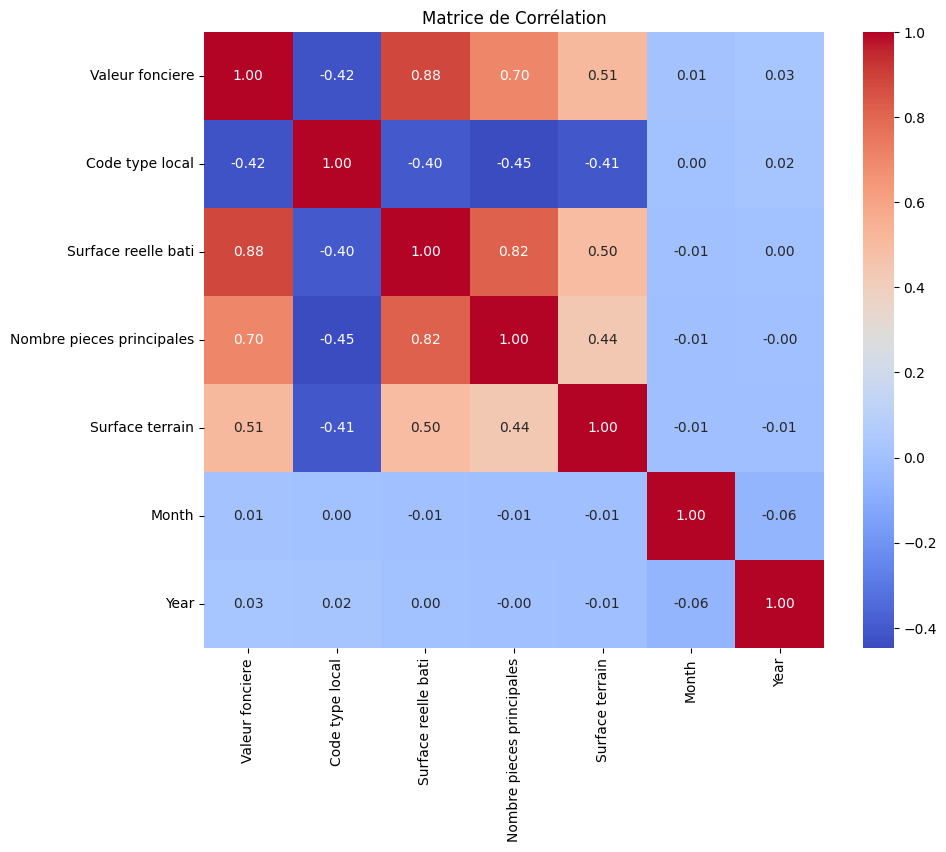

In [251]:
# Utilisation de Seaborn pour créer la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    dataframe_grouped.drop(columns = ["Section"]).corr(), 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm')

# Affichage du graphique
plt.title("Matrice de Corrélation")
plt.show()

# Processing after correlation

In [253]:
dataframe_grouped = dataframe_grouped.drop(columns = ["Surface terrain", "Nombre pieces principales"])

# Train Test Split

In [255]:
from sklearn.model_selection import train_test_split
X = dataframe_grouped.drop(columns = ["Valeur fonciere"])
y = dataframe_grouped[["Valeur fonciere"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=123)
nb_section = X_train.groupby("Section")[["Code type local"]].agg("count").sort_values(by = "Code type local").reset_index()



In [256]:
X_train

,Section,Code type local,Surface reelle bati,Month,Year
adresse,,,,,
36.0 RUE DE LACANAU 33000.02021-08-20 00:00:00275000,LY,1.0,47.0,8,2021
7.0 SEN ARMANDE LACAZE 33100.02022-08-02 00:00:00320000,AF,2.0,61.0,8,2022
88.0 RUE GEORGES MANDEL 33000.02021-04-13 00:00:00412000,LW,1.0,84.0,4,2021
88.0 CRS D ALSACE LORRAINE 33000.02021-08-10 00:00:00475000,HD,2.0,81.0,8,2021
2.0 RUE DES ALLAMANDIERS 33800.02021-07-27 00:00:00237500,DN,2.0,41.0,7,2021
...,...,...,...,...,...
55.0 RUE MAURICE 33300.02021-03-26 00:00:00170000,RP,2.0,45.0,3,2021
11.0 RUE SEGALIER 33000.02020-10-14 00:00:00375000,LA,2.0,73.0,10,2020
5.0 RUE MILLANGES 33000.02020-02-04 00:00:00155150,KI,2.0,28.0,2,2020


# Add geospatial Data to X_train

In [258]:
df_section_grouped = df_section_grouped(df_nb_section = nb_section, df_section_geometry = gdf1, n_min = 100)

section_faible 371
gdf 390


section_faible 130
gdf 172
section_faible 22
gdf 90
section_faible 1
gdf 72


## map Section grouped

In [261]:
# activate Bokeh output in Jupyter notebook
from bokeh.io import output_notebook

output_notebook()
# Assurez-vous que 'geometry_grouped' est la colonne de géométrie
df_section_grouped_plt = df_section_grouped[["Section_grouped","geometry_grouped"]].drop_duplicates()

def extract_xy(poly):
    """
    Extrait les coordonnées x et y d'un polygone Shapely pour Bokeh.
    """
    if isinstance(poly, Polygon):
        return list(poly.exterior.coords.xy)
    else:
        return None, None

# Appliquez cette fonction à votre DataFrame
df_section_grouped_plt['xs'], df_section_grouped_plt['ys'] = zip(*df_section_grouped_plt['geometry_grouped'].apply(extract_xy))
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource

# Convertir les données en source pour Bokeh
source = ColumnDataSource(df_section_grouped_plt[["Section_grouped", "xs", "ys"]])

# Calculer les limites pour la figure
min_x = min(df_section_grouped_plt['xs'].apply(min))
max_x = max(df_section_grouped_plt['xs'].apply(max))
min_y = min(df_section_grouped_plt['ys'].apply(min))
max_y = max(df_section_grouped_plt['ys'].apply(max))

# Créer la figure avec des limites spécifiques
p = figure(x_range=(min_x, max_x), y_range=(min_y, max_y), title="Visualisation des Polygones")

# Tracer les polygones
p.patches('xs', 'ys', source=source, fill_alpha=0.6, line_color="black")

# Afficher le résultat
show(p)

Loading BokehJS ...

## Normalize Lat and long

In [264]:
df_section_grouped_long_lat = df_section_grouped[["Section","longitude", "latitude", "longitude_grouped", "latitude_grouped", "distance"]]

from sklearn.preprocessing import MinMaxScaler
# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Apply fit_transform to your dataframe
df_section_grouped_long_lat[["longitude", "latitude", "longitude_grouped", "latitude_grouped", "distance"]] = scaler.fit_transform(df_section_grouped_long_lat[["longitude", "latitude", "longitude_grouped", "latitude_grouped", "distance"]])


X_train = X_train.merge(df_section_grouped_long_lat, on = "Section", how = "left", validate = "many_to_one").drop(columns = ["Section"])
X_test = X_test.merge(df_section_grouped_long_lat, on = "Section", how = "left", validate = "many_to_one").drop(columns = ["Section"])




C:\Users\azert\AppData\Local\Temp\ipykernel_8832\717824991.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_section_grouped_long_lat[["longitude", "latitude", "longitude_grouped", "latitude_grouped", "distance"]] = scaler.fit_transform(df_section_grouped_long_lat[["longitude", "latitude", "longitude_grouped", "latitude_grouped", "distance"]])


## Correlation

In [265]:
pd.concat([X_train.reset_index(drop = True), y_train.reset_index(drop = True)], axis =1)

,Code type local,Surface reelle bati,Month,Year,longitude,latitude,longitude_grouped,latitude_grouped,distance,Valeur fonciere
0,1.0,47.0,8,2021,0.434278,0.264447,0.445296,0.262726,0.125702,275000
1,2.0,61.0,8,2022,0.873544,0.403891,0.925631,0.410570,0.216390,320000
2,1.0,84.0,4,2021,0.457218,0.299741,0.496340,0.323589,0.121364,412000
3,2.0,81.0,8,2021,0.644801,0.245684,0.668719,0.267174,0.000000,475000
4,2.0,41.0,7,2021,0.727245,0.211428,0.776256,0.204838,0.115793,237500
...,...,...,...,...,...,...,...,...,...,...
12608,2.0,45.0,3,2021,0.723548,0.469015,0.791521,0.484668,0.268756,170000
12609,2.0,73.0,10,2020,0.497860,0.302613,0.496340,0.323589,0.070406,375000
12610,2.0,28.0,2,2020,0.640108,0.265296,0.664256,0.299556,0.040429,155150
12611,2.0,96.0,11,2020,0.537734,0.309766,0.594226,0.350862,0.154092,545000


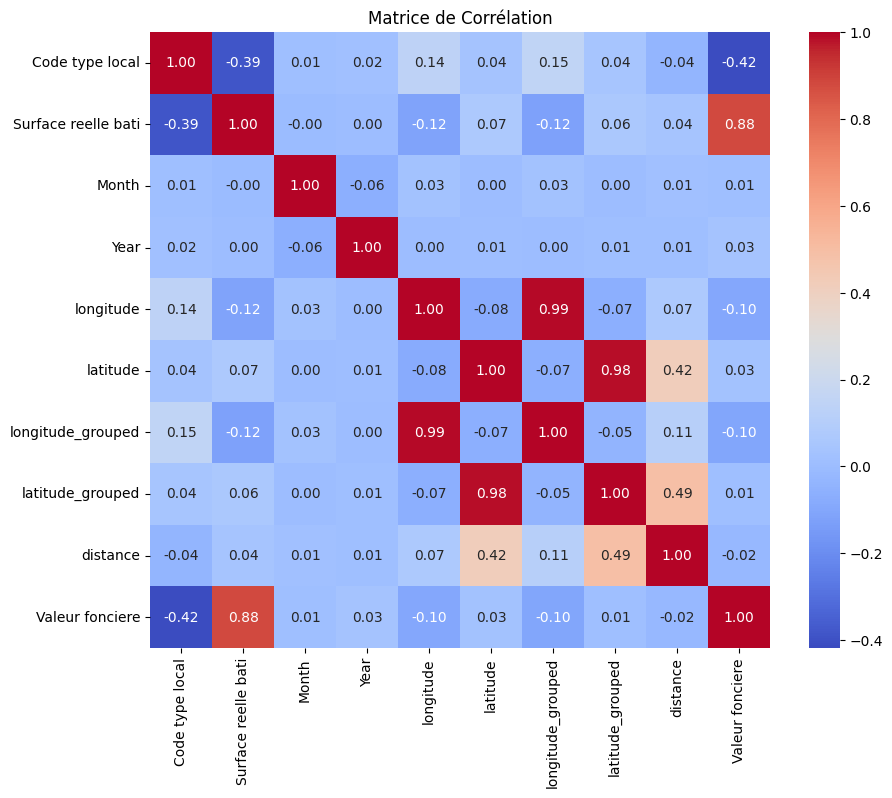

In [266]:
# Utilisation de Seaborn pour créer la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    pd.concat([X_train.reset_index(drop = True), y_train.reset_index(drop = True)], axis =1).corr(), 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm')

# Affichage du graphique
plt.title("Matrice de Corrélation")
plt.show()

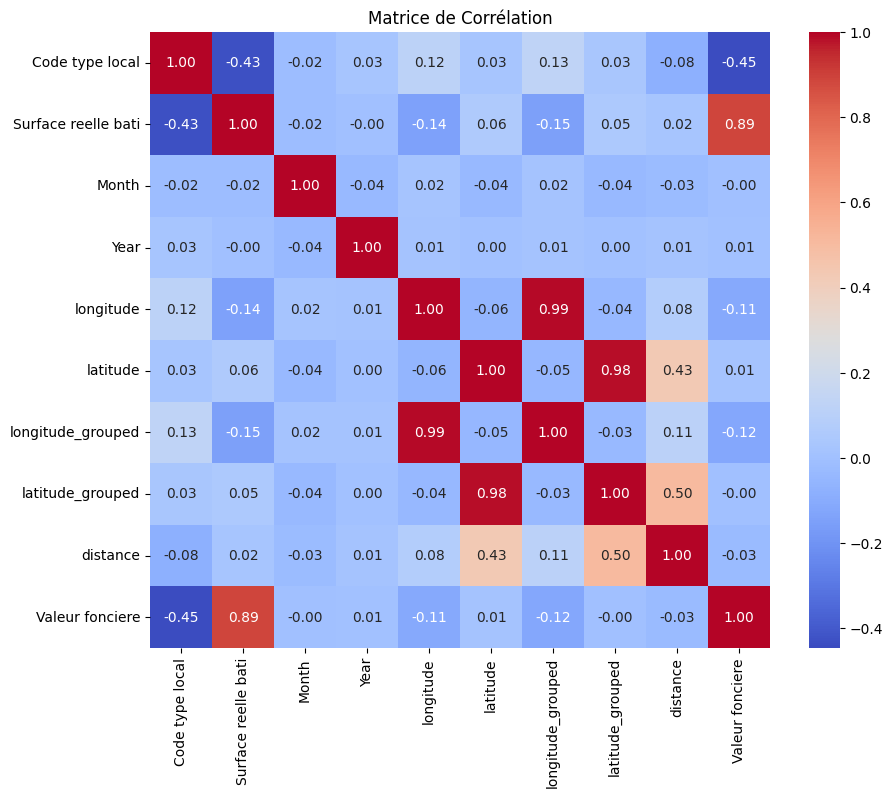

In [267]:
# Utilisation de Seaborn pour créer la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    pd.concat([X_test.reset_index(drop = True), y_test.reset_index(drop = True)], axis = 1).corr(), 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm')

# Affichage du graphique
plt.title("Matrice de Corrélation")
plt.show()

# Normalize not Geospatial data

In [269]:
X_train[['Code type local', 'Surface reelle bati', 'Month','Year']] = X_train[['Code type local', 'Surface reelle bati', 'Month','Year']].apply(normalize, axis = 0)

# New train 2 Dataset section grouped and section not grouped

In [271]:
X_train1 = X_train.drop(columns = ["longitude_grouped", "latitude_grouped"])
X_test1 = X_test.drop(columns = ["longitude_grouped", "latitude_grouped"])

X_train2 = X_train.drop(columns = ["longitude", "latitude"])
X_test2 = X_test.drop(columns = ["longitude", "latitude"])

# Correlation

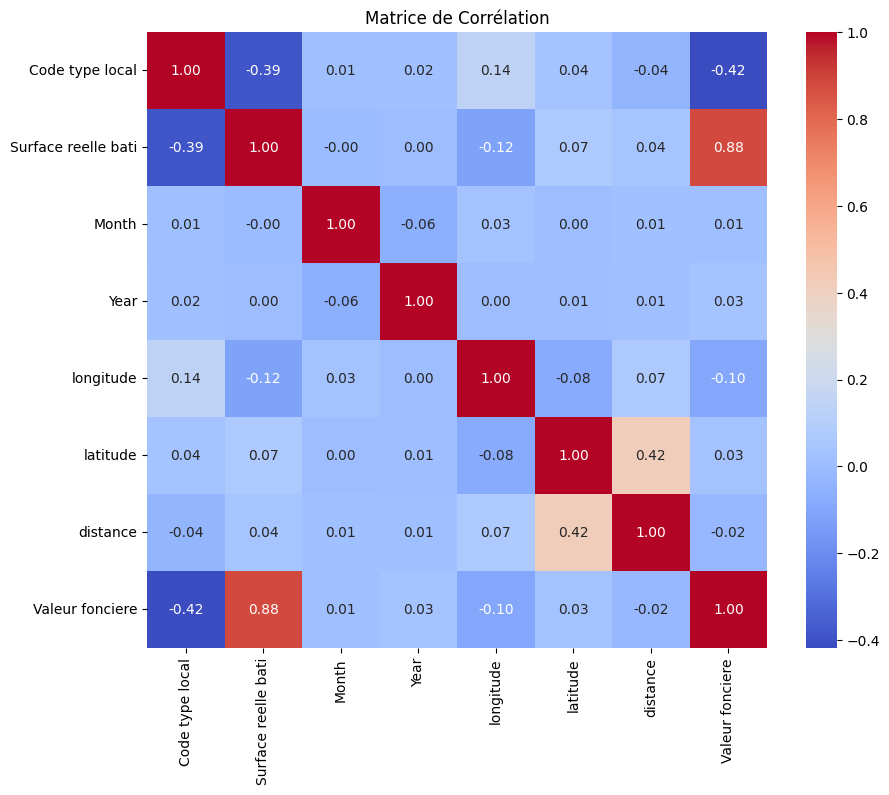

In [272]:
# Utilisation de Seaborn pour créer la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    pd.concat([X_train1.reset_index(drop = True), y_train.reset_index(drop = True)], axis =1).corr(), 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm')

# Affichage du graphique
plt.title("Matrice de Corrélation")
plt.show()

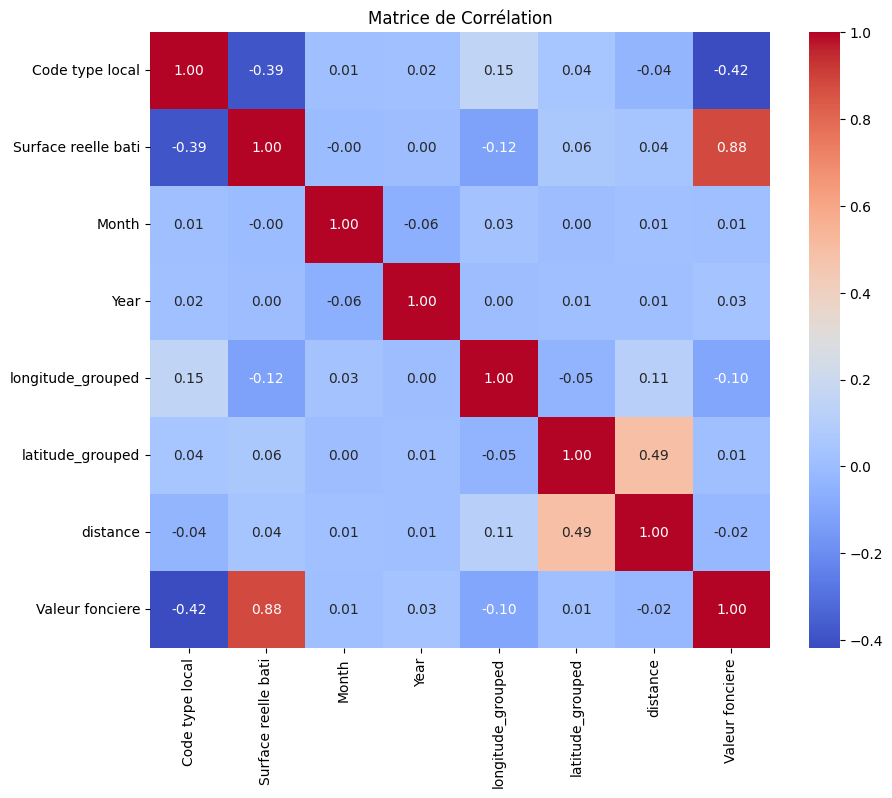

In [273]:
# Utilisation de Seaborn pour créer la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    pd.concat([X_train2.reset_index(drop = True), y_train.reset_index(drop = True)], axis =1).corr(), 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm')

# Affichage du graphique
plt.title("Matrice de Corrélation")
plt.show()

# Deep learning model

In [277]:
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam


# Définition du modèle
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train1.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation='relu')
])

# Configuration de l'optimiseur Nadam
optimizer = Adam(learning_rate=0.001)

# Compilation du modèle
model.compile(optimizer=optimizer, loss = 'mean_squared_error', metrics='mae')


model.fit(
    X_train1, y_train,
    epochs=200,
    validation_data=(X_test1, y_test),)

Epoch 1/200


395/395 [==============================] - 3s 5ms/step - loss: 146157649920.0000 - mae: 266773.3438 - val_loss: 24496668095283200.0000 - val_mae: 150972256.0000
Epoch 2/200
395/395 [==============================] - 2s 5ms/step - loss: 24349913088.0000 - mae: 94546.5859 - val_loss: 163710924824248320.0000 - val_mae: 370992064.0000
Epoch 3/200
395/395 [==============================] - 2s 5ms/step - loss: 22395926528.0000 - mae: 91465.1797 - val_loss: 222142133820194816.0000 - val_mae: 439108032.0000
Epoch 4/200
395/395 [==============================] - 2s 5ms/step - loss: 22016194560.0000 - mae: 90558.6250 - val_loss: 240647069134487552.0000 - val_mae: 461373984.0000
Epoch 5/200
395/395 [==============================] - 2s 5ms/step - loss: 21452216320.0000 - mae: 89240.6797 - val_loss: 305004628624277504.0000 - val_mae: 526623072.0000
Epoch 6/200
395/395 [==============================] - 2s 5ms/step - loss: 21449306112.0000 - mae: 88593.9453 - val_loss: 314873295239380992.0000 - val